## Model Machine Learning dengan Data Time Series





---

Nama : Ridopandi Sinaga

---

Pandas untuk analisa data, dan drive menghubungkan collab ke gdrive

In [1]:
import pandas as pd
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Membaca dataset dan juga menampilkannya

In [2]:
df = pd.read_csv('/content/gdrive/MyDrive/Dicoding/AEP_hourly.csv')
df.info()
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 121273 entries, 0 to 121272
Data columns (total 2 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   Datetime  121273 non-null  object 
 1   AEP_MW    121273 non-null  float64
dtypes: float64(1), object(1)
memory usage: 1.9+ MB


,Datetime,AEP_MW
0,2004-12-31 01:00:00,13478.0
1,2004-12-31 02:00:00,12865.0
2,2004-12-31 03:00:00,12577.0
3,2004-12-31 04:00:00,12517.0
4,2004-12-31 05:00:00,12670.0


Cek keberadaan missing values pada dataset

In [3]:
df.isnull().sum()

Datetime    0
AEP_MW      0
dtype: int64

Menormalisasi dataset

In [4]:
import sklearn.preprocessing

def normalize_data(df):
    scaler = sklearn.preprocessing.MinMaxScaler()
    df['AEP_MW']=scaler.fit_transform(df['AEP_MW'].values.reshape(-1,1))
    return df

df_norm = normalize_data(df)
df_norm.shape

(121273, 2)

Mengubah nilai-nilai pada dataframe ke dalam tipe data numpy array serta menampilkan plotting grafik terhadap dataset

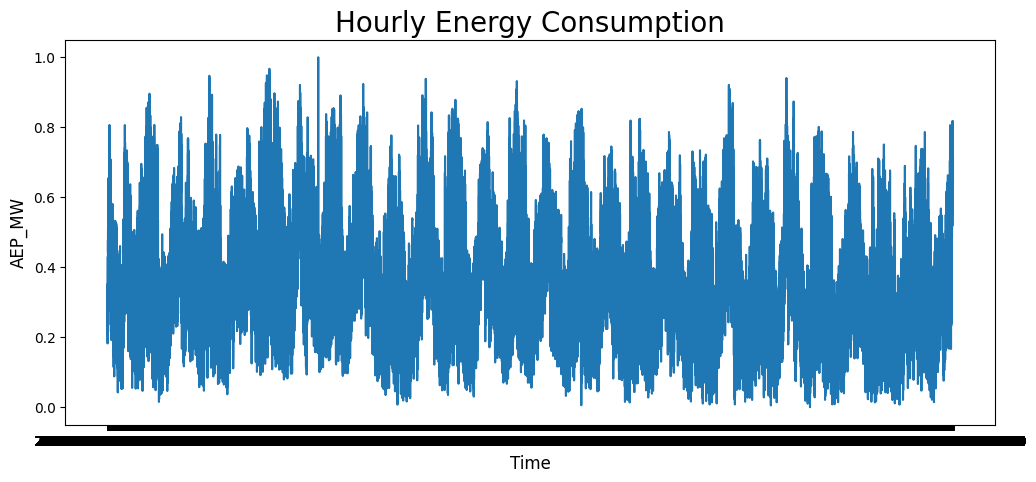

In [6]:
import matplotlib.pyplot as plt

time = df['Datetime'].values
aep = df['AEP_MW'].values

plt.figure(figsize=(12, 5))
plt.plot(time, aep)
plt.title('Hourly Energy Consumption', fontsize=20)
plt.xlabel('Time', fontsize=12)
plt.ylabel('AEP_MW', fontsize=12)
plt.show()

Tampilkan bentuk data dan tipe data

In [7]:
df_norm.shape
df.dtypes

Datetime     object
AEP_MW      float64
dtype: object

Membagi dataset menjadi train set dan validation set

In [8]:
from sklearn.model_selection import train_test_split

xTrain, xTest, yTrain, yTest = train_test_split(aep, time,train_size=0.8, test_size=0.2, shuffle=False)

print('Total Data Train : ',len(xTrain))
print('Total Data Validation : ',len(xTest))

Total Data Train :  97018
Total Data Validation :  24255


Fungsi untuk menerima sebuah series/atribut  yang telah di konversi menjadi tipe numpy, lalu mengembalikan label dan atribut dari dataset dalam bentuk batch.

In [9]:
import tensorflow as tf

def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  ds = ds.shuffle(shuffle_buffer)
  ds = ds.map(lambda w: (w[:-1], w[-1:]))
  return ds.batch(batch_size).prefetch(1)

Arsitektur model

In [11]:
import sklearn.preprocessing
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional, Dropout
from sklearn.metrics import r2_score

train_set = windowed_dataset(xTrain, window_size=60, batch_size=200, shuffle_buffer=1000)
test_set  = windowed_dataset(xTest, window_size=60, batch_size=200, shuffle_buffer=1000)

model = tf.keras.models.Sequential([
  Bidirectional(tf.keras.layers.LSTM(60, return_sequences=True)),
  Bidirectional(tf.keras.layers.LSTM(60, dropout=0.2)),
  Dense(16, activation="relu"),
  Dense(8, activation="relu"),
  Dense(4, activation="relu"),
  Dropout(0.2),
  Dense(1),
])

optimizer = tf.keras.optimizers.SGD(learning_rate=1e-3, momentum=0.9)

model.compile(
    loss=tf.keras.losses.Huber(),
    optimizer=optimizer,
    metrics=["mae"]
    )

Pengecekan nilai MAE dari model < 10% skala data

In [12]:
minMae = (aep.max() - aep.min()) * 10/100
print(minMae)

0.09999999999999998


Fungsi callback untuk hentikan training

In [13]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('mae') < minMae and logs.get('val_mae') < minMae):
      print("\MAE dari model < 10% skala data")
      self.model.stop_training = True

stopTraining = myCallback()

Training model

In [14]:
epoch = 70

history = model.fit(
    train_set,
    epochs= epoch,
    steps_per_epoch = 10,
    validation_data=test_set,
    verbose         = 2,
    callbacks=[stopTraining])

Epoch 1/70
10/10 - 18s - loss: 0.0820 - mae: 0.3795 - val_loss: 0.0614 - val_mae: 0.3116 - 18s/epoch - 2s/step
Epoch 2/70
10/10 - 6s - loss: 0.0615 - mae: 0.3191 - val_loss: 0.0462 - val_mae: 0.2612 - 6s/epoch - 575ms/step
Epoch 3/70
10/10 - 6s - loss: 0.0641 - mae: 0.3124 - val_loss: 0.0336 - val_mae: 0.2130 - 6s/epoch - 552ms/step
Epoch 4/70
10/10 - 7s - loss: 0.0350 - mae: 0.2088 - val_loss: 0.0248 - val_mae: 0.1768 - 7s/epoch - 652ms/step
Epoch 5/70
10/10 - 5s - loss: 0.0282 - mae: 0.2000 - val_loss: 0.0196 - val_mae: 0.1544 - 5s/epoch - 550ms/step
Epoch 6/70
10/10 - 6s - loss: 0.0226 - mae: 0.1741 - val_loss: 0.0159 - val_mae: 0.1381 - 6s/epoch - 613ms/step
Epoch 7/70
10/10 - 5s - loss: 0.0193 - mae: 0.1555 - val_loss: 0.0141 - val_mae: 0.1301 - 5s/epoch - 501ms/step
Epoch 8/70
10/10 - 6s - loss: 0.0225 - mae: 0.1671 - val_loss: 0.0130 - val_mae: 0.1263 - 6s/epoch - 550ms/step
Epoch 9/70
10/10 - 11s - loss: 0.0127 - mae: 0.1232 - val_loss: 0.0126 - val_mae: 0.1255 - 11s/epoch - 1s

10/10 - 8s - loss: 0.0070 - mae: 0.0959 - val_loss: 0.0120 - val_mae: 0.1239 - 8s/epoch - 764ms/step


Diagram history model mae dan loss

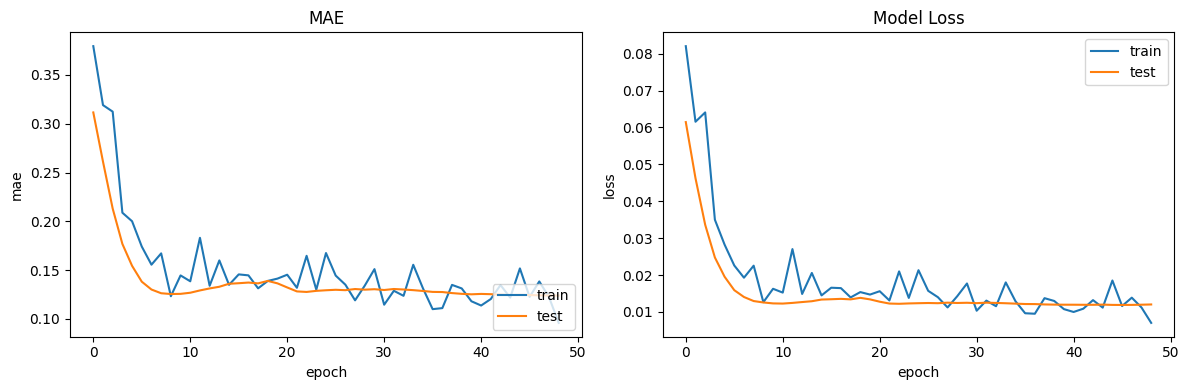

In [22]:
import matplotlib.pyplot as plt

# plot of mae
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plot MAE
axs[0].plot(history.history['mae'])
axs[0].plot(history.history['val_mae'])
axs[0].set_title('MAE')
axs[0].set_ylabel('mae')
axs[0].set_xlabel('epoch')
axs[0].legend(['train', 'test'], loc='lower right')

# Plot Loss
axs[1].plot(history.history['loss'])
axs[1].plot(history.history['val_loss'])
axs[1].set_title('Model Loss')
axs[1].set_ylabel('loss')
axs[1].set_xlabel('epoch')
axs[1].legend(['train', 'test'], loc='upper right')

plt.tight_layout()
plt.show()